In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, datetime
import glob
import numpy as np

# Utility Functions

## xlsx -> dataframe, xlsx -> unified plc/mes

In [2]:
def xlsx_to_dataframe(filename):
    df = pd.read_excel(filename, sheet_name=None)
    df = pd.concat(df.values(), ignore_index=True)
    return df

def xlsx_to_dataframe_specific(filenames, x1='01.A.PLC.Raw', x2='01.B.MES.Raw'):
    # filenames is the list containing the xlsx files, here is the 05/06/07 months
    df1 = pd.read_excel(filenames[0], sheet_name=x1)
    df2 = pd.read_excel(filenames[0], sheet_name=x2)
    df3 = pd.read_excel(filenames[1], sheet_name=x1)
    df4 = pd.read_excel(filenames[1], sheet_name=x2)
    df5 = pd.read_excel(filenames[2], sheet_name=x1)
    df6 = pd.read_excel(filenames[2], sheet_name=x2)

    df_plc = pd.concat([df1, df3, df5], ignore_index=True)
    df_mes = pd.concat([df2, df4, df6], ignore_index=True)
    columns_to_keep_plc = ['Calendar (Production) date', 'Product Group', 'SKU code', 'Event Code',
       'Production Quantity (#) ', 'Duration (sec)', 'Start time', 'End time',
       'PLC Production Date', 'Καθαρές Μηχανοώρες (min)']
    
    columns_to_keep_mes = ['Work Center', 'Start Time', 'End Time', 'Περιγραφή υλικού',
       'Event Code', 'Duration (min)', 'Production Quantity (#)']

    df_plc = df_plc.filter(items=columns_to_keep_plc)
    df_mes = df_mes.filter(items=columns_to_keep_mes)
    return df_plc, df_mes

# Export as .csv the necessary columns from Exports_BEST

In [3]:
df_plc, df_mes= xlsx_to_dataframe_specific(["./Data/Exports_BEST/Monthly Loss Tree 05.2022 (Weeks 18, 19, 20, 21).xlsm", "./Data/Exports_BEST/Loss Tree_Month 6.2022_v11.8.xlsm", "./Data/Exports_BEST/Loss Tree_Month 7.2022_v12.2 (Weeks 27, 28, 29, 30).xlsm"])
df_plc= df_plc.drop_duplicates().dropna()
df_plc = df_plc[:-1]
df_mes = df_mes.drop_duplicates().dropna()
# df_plc = df_plc.sort_values(by='Calendar (Production) date')

# Concatenate all energies together for each timestamp

In [4]:
total_energy = None
for filename in os.listdir("./Data/Data_Energy_Consumptions"):
    f = os.path.join("./Data/Data_Energy_Consumptions", filename)
    df = xlsx_to_dataframe(f)
    df.drop(columns="Reactive Energy Into the Load", inplace=True)
    df['Real Energy'] = pd.to_numeric(df['Real Energy'], downcast='float', errors='coerce')
    # df = df.dropna()
    df = df.sort_values(by='Timestamp', ascending= True)
    # the '-' rows should be filled with the previous value instead (the previous 15-minute)
    df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
    # df['Real Energy'] = df['Real Energy'].fillna(df['Real Energy'].rolling(3, min_periods=1).mean()) # Rolling Mean/Median Imputation
    df['Real Energy'] = df['Real Energy'].interpolate()
    # df = df.fillna(method='ffill')
    if total_energy is None:
        total_energy = df
    else:
        total_energy = pd.concat([df, total_energy], ignore_index=True)
        total_energy = total_energy.groupby('Timestamp').sum().reset_index()

total_energy['Timestamp'] = total_energy['Timestamp'].dt.floor('min')
total_energy['Timestamp'] = pd.to_datetime(total_energy['Timestamp'])

# remove the two rows from the dataframe that are outliers
print(len(total_energy))
total_energy = total_energy[total_energy['Timestamp'] != '2022-07-01 07:15:00']
total_energy = total_energy[total_energy['Timestamp'] != '2022-06-01 07:15:00']
print(len(total_energy))


/tmp/ipykernel_47893/3243412493.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/tmp/ipykernel_47893/3243412493.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/tmp/ipykernel_47893/3243412493.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/tmp/ipykernel_47893/3243412493.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/tmp/ipykernel_47893/3243412493.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFr

8544
8542


/tmp/ipykernel_47893/3243412493.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later


In [5]:
total_energy.set_index('Timestamp', inplace=True)
total_energy = total_energy.resample('15min', closed='right', label='right').sum()
total_energy.replace(0, np.nan, inplace=True)
total_energy = total_energy.interpolate()
total_energy.reset_index(inplace=True)
total_energy['diff'] = total_energy['Real Energy'].diff()
total_energy

,Timestamp,Real Energy,diff
0,2022-05-01 07:15:00,3.242401e+07,NaN
1,2022-05-01 07:30:00,3.242436e+07,355.1045
2,2022-05-01 07:45:00,3.242468e+07,315.0265
3,2022-05-01 08:00:00,3.242497e+07,290.2740
4,2022-05-01 08:15:00,3.242529e+07,319.6450
...,...,...,...
8731,2022-07-31 06:00:00,3.416969e+07,342.2530
8732,2022-07-31 06:15:00,3.416998e+07,293.8800
8733,2022-07-31 06:30:00,3.417021e+07,234.8400
8734,2022-07-31 06:45:00,3.417025e+07,33.5700


# BEST PLC.RAW records

In [6]:
plcBestframe = pd.read_csv("./Data/Exports_BEST/PLC_RAW.csv",delimiter=';').drop_duplicates().dropna()
plcBestframe['Timestamp'] = plcBestframe[['Calendar (Production) date','End time']].T.agg(lambda x: (x.values[0]+' '+x.values[1]))
plcBestframe['Timestamp'] = pd.to_datetime(plcBestframe['Timestamp'], format='%Y-%m-%d %H:%M:%S')
# plcBestframe['Καθαρές Μηχανοώρες (min)'] = plcBestframe[['Καθαρές Μηχανοώρες (min)']].T.agg(lambda x: x.values[0].replace('.','').replace(',','.')).astype('float64')
plcBestframe = plcBestframe.drop(columns=['Calendar (Production) date','End time','Start time','PLC Production Date'])
plcBestframe.drop("Unnamed: 0", axis= 1)
timeWindows = total_energy['Timestamp'].tolist()
timeWindows.insert(0, pd.to_datetime('2022-05-01 00:00:00', format='%Y-%m-%d %H:%M:%S'))
labels = total_energy['Timestamp'].tolist()
plcBestframe['Time Bin'] = pd.cut(plcBestframe['Timestamp'], timeWindows, labels= labels, right=False)
plcBestframe.drop("Unnamed: 0", axis= 1, inplace=True)


In [7]:
plcBestframe['Product Group'] = plcBestframe['Product Group'].astype('str')
plcBestframe['SKU code'] = plcBestframe['SKU code'].astype('str')
plcBestframe['Event Code'] = plcBestframe['Event Code'].astype('str')
plcBestframe = plcBestframe.groupby('Time Bin', sort=True).agg({'Product Group':set,'SKU code':set,'Event Code':set,'Production Quantity (#) ':sum,'Duration (sec)':sum,'Καθαρές Μηχανοώρες (min)':sum}).reset_index()
plcBestframe

/tmp/ipykernel_47893/166321637.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plcBestframe = plcBestframe.groupby('Time Bin', sort=True).agg({'Product Group':set,'SKU code':set,'Event Code':set,'Production Quantity (#) ':sum,'Duration (sec)':sum,'Καθαρές Μηχανοώρες (min)':sum}).reset_index()
/tmp/ipykernel_47893/166321637.py:4: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  plcBestframe = plcBestframe.groupby('Time Bin', sort=True).agg({'Product Group':set,'SKU code':set,'Event Code':set,'Production Quantity (#) ':sum,'Duration (sec)':sum,'Καθαρές Μηχανοώρες (min)':sum}).reset_index()


,Time Bin,Product Group,SKU code,Event Code,Production Quantity (#),Duration (sec),Καθαρές Μηχανοώρες (min)
0,2022-05-01 07:15:00,{DB3},{1.0},{98.0},1.0,105.0,0.000000
1,2022-05-01 07:30:00,{},{},{},0.0,0.0,0.000000
2,2022-05-01 07:45:00,{DB3},{1.0},{99.0},23.0,2053.0,34.216667
3,2022-05-01 08:00:00,{DB3},{1.0},"{901.0, 98.0}",2.0,465.0,0.000000
4,2022-05-01 08:15:00,{DB3},{1.0},"{99.0, 98.0}",15.0,1505.0,21.283333
...,...,...,...,...,...,...,...
8731,2022-07-31 06:00:00,{},{},{},0.0,0.0,0.000000
8732,2022-07-31 06:15:00,{},{},{},0.0,0.0,0.000000
8733,2022-07-31 06:30:00,{DB3},{1.0},"{901.0, 99.0, 98.0}",38.0,3843.0,56.266667
8734,2022-07-31 06:45:00,{},{},{},0.0,0.0,0.000000


# BEST MES.RAW records

In [8]:
mesBestframe = pd.read_csv("./Data/Exports_BEST/MES_RAW.csv",delimiter=';').drop_duplicates().dropna()
timeWindows = total_energy['Timestamp'].tolist()
timeWindows.insert(0, pd.to_datetime('2022-05-01 00:00:00', format='%Y-%m-%d %H:%M:%S'))
labels = total_energy['Timestamp'].tolist()
mesBestframe['Time Bin'] = pd.cut(mesBestframe['End Time'], timeWindows, labels=labels, right=False)
mesBestframe.drop("Unnamed: 0", axis= 1, inplace=True)
mesBestframe = mesBestframe[:-1]
# mesBestframe

In [9]:
mesBestframe['Περιγραφή υλικού'] = mesBestframe['Περιγραφή υλικού'].astype('str')
mesBestframe['Work Center'] = mesBestframe['Work Center'].astype('str')
mesBestframe['Event Code'] = mesBestframe['Event Code'].astype('str')
mesBestframe = mesBestframe.groupby('Time Bin', sort=True).agg({'Περιγραφή υλικού':set,'Work Center':set,'Event Code':set,'Production Quantity (#)':sum,'Duration (min)':sum}).reset_index()
mesBestframe

/tmp/ipykernel_47893/1355933840.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mesBestframe = mesBestframe.groupby('Time Bin', sort=True).agg({'Περιγραφή υλικού':set,'Work Center':set,'Event Code':set,'Production Quantity (#)':sum,'Duration (min)':sum}).reset_index()
/tmp/ipykernel_47893/1355933840.py:4: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  mesBestframe = mesBestframe.groupby('Time Bin', sort=True).agg({'Περιγραφή υλικού':set,'Work Center':set,'Event Code':set,'Production Quantity (#)':sum,'Duration (min)':sum}).reset_index()


,Time Bin,Περιγραφή υλικού,Work Center,Event Code,Production Quantity (#),Duration (min)
0,2022-05-01 07:15:00,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}","{70.0, 99.0, 0.0}",2,19.133333
1,2022-05-01 07:30:00,"{M. TUBE 35,00x1,65 DAN2 DHPCu D1}",{S_DAN2},{99.0},0,5.600000
2,2022-05-01 07:45:00,"{M. TUBE 76,00x3,10 SCHU4B DHPCu D1}",{S_SCH4B},{99.0},0,41.800000
3,2022-05-01 08:00:00,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}",{70.0},22,77.666667
4,2022-05-01 08:15:00,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}","{70.0, 99.0}",3,33.566667
...,...,...,...,...,...,...
8731,2022-07-31 06:00:00,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}",{99.0},0,16.866667
8732,2022-07-31 06:15:00,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}",{70.0},15,44.083333
8733,2022-07-31 06:30:00,"{M. TUBE 76,00x3,10 SCHU4B DHPCu D1}",{S_SCH4B},{70.0},41,93.516667
8734,2022-07-31 06:45:00,{},{},{},0,0.000000


In [10]:
bestFrame = plcBestframe.join(mesBestframe.set_index('Time Bin'), on='Time Bin', lsuffix='_plc',rsuffix='_mes')
bestFrame.rename(columns={'Production Quantity (#) ': 'products_plc', 'Production Quantity (#)':'products_mes'}, inplace=True)
bestFrame['Production Quantity (#)'] = bestFrame['products_plc'] + bestFrame['products_mes']

In [11]:
bestFrame

,Time Bin,Product Group,SKU code,Event Code_plc,products_plc,Duration (sec),Καθαρές Μηχανοώρες (min),Περιγραφή υλικού,Work Center,Event Code_mes,products_mes,Duration (min),Production Quantity (#)
0,2022-05-01 07:15:00,{DB3},{1.0},{98.0},1.0,105.0,0.000000,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}","{70.0, 99.0, 0.0}",2,19.133333,3.0
1,2022-05-01 07:30:00,{},{},{},0.0,0.0,0.000000,"{M. TUBE 35,00x1,65 DAN2 DHPCu D1}",{S_DAN2},{99.0},0,5.600000,0.0
2,2022-05-01 07:45:00,{DB3},{1.0},{99.0},23.0,2053.0,34.216667,"{M. TUBE 76,00x3,10 SCHU4B DHPCu D1}",{S_SCH4B},{99.0},0,41.800000,23.0
3,2022-05-01 08:00:00,{DB3},{1.0},"{901.0, 98.0}",2.0,465.0,0.000000,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}",{70.0},22,77.666667,24.0
4,2022-05-01 08:15:00,{DB3},{1.0},"{99.0, 98.0}",15.0,1505.0,21.283333,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}","{70.0, 99.0}",3,33.566667,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,2022-07-31 06:00:00,{},{},{},0.0,0.0,0.000000,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}",{99.0},0,16.866667,0.0
8732,2022-07-31 06:15:00,{},{},{},0.0,0.0,0.000000,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}",{70.0},15,44.083333,15.0
8733,2022-07-31 06:30:00,{DB3},{1.0},"{901.0, 99.0, 98.0}",38.0,3843.0,56.266667,"{M. TUBE 76,00x3,10 SCHU4B DHPCu D1}",{S_SCH4B},{70.0},41,93.516667,79.0
8734,2022-07-31 06:45:00,{},{},{},0.0,0.0,0.000000,{},{},{},0,0.000000,0.0


# Merge MES and PLC dataframes

In [12]:
#Merge MES and PLC dataframes
# bestFrame = plcBestframe.set_index('Time Bin').join(mesBestframe.set_index('Time Bin'), lsuffix='out_',rsuffix='in_')

# Define the specific combination to match
target_row = {
    'Product Group': set,
    'SKU code': set,
    'Event Code_plc': set,
    'products_plc': 0.0,
    'Duration (sec)': 0.0,
    'Καθαρές Μηχανοώρες (min)': 0.0,
    'Περιγραφή υλικού': set,
    'Work Center': set,
    'Event Code_mes': set,
    'products_mes': 0.0,
    'Duration (min)': 0.0,
    'Production Quantity (#)': 0.0
}
# Create a boolean mask to identify rows that match the combination
mask = (
    (bestFrame['Product Group'] == target_row['Product Group']) &
    (bestFrame['SKU code'] == target_row['SKU code']) &
    (bestFrame['Event Code_plc'] == target_row['Event Code_plc']) &
    (bestFrame['products_plc'] == target_row['products_plc']) &
    (bestFrame['Duration (sec)'] == target_row['Duration (sec)']) &
    (bestFrame['Καθαρές Μηχανοώρες (min)'] == target_row['Καθαρές Μηχανοώρες (min)']) &
    (bestFrame['Περιγραφή υλικού'] == target_row['Περιγραφή υλικού']) &
    (bestFrame['Work Center'] == target_row['Work Center']) &
    (bestFrame['Event Code_mes'] == target_row['Event Code_mes']) &
    (bestFrame['products_mes'] == target_row['products_mes']) &
    (bestFrame['Duration (min)'] == target_row['Duration (min)']) &
    (bestFrame['Production Quantity (#)'] == target_row['Production Quantity (#)'])
)
bestFrame = bestFrame[~mask]
bestFrame

,Time Bin,Product Group,SKU code,Event Code_plc,products_plc,Duration (sec),Καθαρές Μηχανοώρες (min),Περιγραφή υλικού,Work Center,Event Code_mes,products_mes,Duration (min),Production Quantity (#)
0,2022-05-01 07:15:00,{DB3},{1.0},{98.0},1.0,105.0,0.000000,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}","{70.0, 99.0, 0.0}",2,19.133333,3.0
1,2022-05-01 07:30:00,{},{},{},0.0,0.0,0.000000,"{M. TUBE 35,00x1,65 DAN2 DHPCu D1}",{S_DAN2},{99.0},0,5.600000,0.0
2,2022-05-01 07:45:00,{DB3},{1.0},{99.0},23.0,2053.0,34.216667,"{M. TUBE 76,00x3,10 SCHU4B DHPCu D1}",{S_SCH4B},{99.0},0,41.800000,23.0
3,2022-05-01 08:00:00,{DB3},{1.0},"{901.0, 98.0}",2.0,465.0,0.000000,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}",{70.0},22,77.666667,24.0
4,2022-05-01 08:15:00,{DB3},{1.0},"{99.0, 98.0}",15.0,1505.0,21.283333,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}","{70.0, 99.0}",3,33.566667,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,2022-07-31 06:00:00,{},{},{},0.0,0.0,0.000000,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}",{99.0},0,16.866667,0.0
8732,2022-07-31 06:15:00,{},{},{},0.0,0.0,0.000000,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}",{70.0},15,44.083333,15.0
8733,2022-07-31 06:30:00,{DB3},{1.0},"{901.0, 99.0, 98.0}",38.0,3843.0,56.266667,"{M. TUBE 76,00x3,10 SCHU4B DHPCu D1}",{S_SCH4B},{70.0},41,93.516667,79.0
8734,2022-07-31 06:45:00,{},{},{},0.0,0.0,0.000000,{},{},{},0,0.000000,0.0


# Merge ENERGY and MES/PLC dataframes

In [13]:
bestFrame['Time Bin'] = pd.to_datetime(bestFrame['Time Bin'], errors='raise')
total_energy.set_index('Timestamp', inplace=True)
bestFrame.set_index('Time Bin', inplace=True)
total_energy1 = total_energy.join(bestFrame, lsuffix='out_', rsuffix='in_')
total_energy1.reset_index(inplace=True)

In [14]:
total_energy1

,Timestamp,Real Energy,diff,Product Group,SKU code,Event Code_plc,products_plc,Duration (sec),Καθαρές Μηχανοώρες (min),Περιγραφή υλικού,Work Center,Event Code_mes,products_mes,Duration (min),Production Quantity (#)
0,2022-05-01 07:15:00,3.242401e+07,NaN,{DB3},{1.0},{98.0},1.0,105.0,0.000000,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}","{70.0, 99.0, 0.0}",2,19.133333,3.0
1,2022-05-01 07:30:00,3.242436e+07,355.1045,{},{},{},0.0,0.0,0.000000,"{M. TUBE 35,00x1,65 DAN2 DHPCu D1}",{S_DAN2},{99.0},0,5.600000,0.0
2,2022-05-01 07:45:00,3.242468e+07,315.0265,{DB3},{1.0},{99.0},23.0,2053.0,34.216667,"{M. TUBE 76,00x3,10 SCHU4B DHPCu D1}",{S_SCH4B},{99.0},0,41.800000,23.0
3,2022-05-01 08:00:00,3.242497e+07,290.2740,{DB3},{1.0},"{901.0, 98.0}",2.0,465.0,0.000000,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}",{70.0},22,77.666667,24.0
4,2022-05-01 08:15:00,3.242529e+07,319.6450,{DB3},{1.0},"{99.0, 98.0}",15.0,1505.0,21.283333,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}","{70.0, 99.0}",3,33.566667,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,2022-07-31 06:00:00,3.416969e+07,342.2530,{},{},{},0.0,0.0,0.000000,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}",{99.0},0,16.866667,0.0
8732,2022-07-31 06:15:00,3.416998e+07,293.8800,{},{},{},0.0,0.0,0.000000,"{M. TUBE 48,00x1,70 DAN1 DHPCu D1, M. TUBE 35,...","{S_DAN2, S_DAN1}",{70.0},15,44.083333,15.0
8733,2022-07-31 06:30:00,3.417021e+07,234.8400,{DB3},{1.0},"{901.0, 99.0, 98.0}",38.0,3843.0,56.266667,"{M. TUBE 76,00x3,10 SCHU4B DHPCu D1}",{S_SCH4B},{70.0},41,93.516667,79.0
8734,2022-07-31 06:45:00,3.417025e+07,33.5700,{},{},{},0.0,0.0,0.000000,{},{},{},0,0.000000,0.0


# PLC Analyzer -> functions to combine every csv together to a big dataframe

In [15]:
def load_all_csv_PLC():
    csv_list = []
    dir_path = "./Data/Data_PLC_Analyzer"
    # Use glob to get all the CSV files in the main directory and its subdirectories
    all_files = glob.glob(os.path.join(dir_path, '**', '*.csv'), recursive=True)
    for file in all_files:
        df = pd.read_csv(file, sep=';', encoding='utf-8')
        csv_list.append(df)

    plc_anal_df = pd.concat(csv_list, ignore_index=True)
    return plc_anal_df

In [16]:
plc_anal_df = load_all_csv_PLC()

In [17]:
plc_anal_df.drop(columns = ['DB  802DBX    2.6   fault  pressure', 'DB  802DBX    2.5    fault flow', 'I    265.0', 'I    265.1'], inplace = True)
plc_anal_df['Timestamp'] = plc_anal_df[['Datum','Absolutzeit']].T.agg(lambda x: (x.values[0]+' '+x.values[1]))

In [18]:
plc_anal_df['Timestamp'] = pd.to_datetime(plc_anal_df['Timestamp'], format='%d.%m.%Y %H:%M:%S.%f').dt.strftime('%Y-%m-%d %H:%M:%S')
plc_anal_df['Timestamp'] = pd.to_datetime(plc_anal_df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
plc_anal_df.drop(columns = ['Datum', 'Absolutzeit', 'Relativzeit'], inplace=True)
#replace 2021 to 2022 in timestamps
plc_anal_df['Timestamp'] = plc_anal_df['Timestamp'].apply(lambda x: x.replace(year=2022) if x.year == 2021 else x)
#create time bins
timeWindows = total_energy1['Timestamp'].tolist()
timeWindows.insert(0, pd.to_datetime('2022-05-01 00:00:00', format='%Y-%m-%d %H:%M:%S'))
labels = total_energy1['Timestamp'].tolist()
plc_anal_df['Time Bin'] = pd.cut(plc_anal_df['Timestamp'], timeWindows, labels=labels, right=False)
plc_anal_df = plc_anal_df.groupby('Time Bin').mean().reset_index()
plc_anal_df.drop(columns = ['Timestamp','Trigger','Fehler'], inplace=True)

/tmp/ipykernel_47893/2636856363.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plc_anal_df = plc_anal_df.groupby('Time Bin').mean().reset_index()


# Merge Energy and PLC Analyzer

In [19]:
total_energy1.set_index('Timestamp', inplace=True)
plc_anal_df.set_index('Time Bin', inplace=True)
total_energy1 = total_energy1.join(plc_anal_df, lsuffix='out_', rsuffix='in_')
total_energy1.reset_index(inplace=True)
total_energy1.drop(columns = ['products_plc','products_mes', 'Περιγραφή υλικού'], inplace=True)
total_energy1 = total_energy1.applymap(lambda x : np.nan if not x else x) # convert empty sets into nan so i can do fillna later

/tmp/ipykernel_47893/3911149628.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  total_energy1 = total_energy1.applymap(lambda x : np.nan if not x else x) # convert empty sets into nan so i can do fillna later


In [20]:
# forward fill seems appropriate for this kind of data to fill the NaN values, since we want to maintain the temporal consistency
total_energy1 = total_energy1.fillna(method='ffill').fillna(method='bfill')
total_energy1.isna().any()

/tmp/ipykernel_47893/2110941883.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  total_energy1 = total_energy1.fillna(method='ffill').fillna(method='bfill')


Timestamp                                        False
Real Energy                                      False
diff                                             False
Product Group                                    False
SKU code                                         False
Event Code_plc                                   False
Duration (sec)                                   False
Καθαρές Μηχανοώρες (min)                         False
Work Center                                      False
Event Code_mes                                   False
Duration (min)                                   False
Production Quantity (#)                          False
DB  955DBW    8   in die side                    False
DB  955DBW   12  in center                       False
DB  955DBW   16  in stem side                    False
MW   960  diff die                               False
MW   962  diff stem                              False
MW   964  dif cont disk                          False
DB   10DBW

In [21]:
total_energy1.to_csv('./Data/data.csv', encoding="utf-8")

In [22]:
total_energy1

,Timestamp,Real Energy,diff,Product Group,SKU code,Event Code_plc,Duration (sec),Καθαρές Μηχανοώρες (min),Work Center,Event Code_mes,...,DB 2000DBW 56 man counter,DB 700DBW 46 contener counter,DB 301DBW 272 cooling water mandrel outlet,DB 301DBW 274 cooling water mandrel inlet,DB 301DBW 276 mandrel coolng flow,DB 301DBW 96 mandrell movment,DB 30DBW 80 contener position,DB 10DBW 114 cont cooling air flow,MW 46 mikos bigetas,DB 301DBW 166 mikos solinas
0,2022-05-01 07:15:00,3.242401e+07,355.1045,{DB3},{1.0},{98.0},105.0,34.216667,"{S_DAN2, S_DAN1}","{70.0, 99.0, 0.0}",...,525.674877,2047.674877,66.482759,59.000000,169.118227,61.586207,14.746305,480.435961,816.012315,305.019704
1,2022-05-01 07:30:00,3.242436e+07,355.1045,{DB3},{1.0},{98.0},105.0,34.216667,{S_DAN2},{99.0},...,525.674877,2047.674877,66.482759,59.000000,169.118227,61.586207,14.746305,480.435961,816.012315,305.019704
2,2022-05-01 07:45:00,3.242468e+07,315.0265,{DB3},{1.0},{99.0},2053.0,34.216667,{S_SCH4B},{99.0},...,525.674877,2047.674877,66.482759,59.000000,169.118227,61.586207,14.746305,480.435961,816.012315,305.019704
3,2022-05-01 08:00:00,3.242497e+07,290.2740,{DB3},{1.0},"{901.0, 98.0}",465.0,34.216667,"{S_DAN2, S_DAN1}",{70.0},...,525.674877,2047.674877,66.482759,59.000000,169.118227,61.586207,14.746305,480.435961,816.012315,305.019704
4,2022-05-01 08:15:00,3.242529e+07,319.6450,{DB3},{1.0},"{99.0, 98.0}",1505.0,21.283333,"{S_DAN2, S_DAN1}","{70.0, 99.0}",...,525.674877,2047.674877,66.482759,59.000000,169.118227,61.586207,14.746305,480.435961,816.012315,305.019704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,2022-07-31 06:00:00,3.416969e+07,342.2530,{DB3},{1.0},"{710.0, 99.0, 98.0}",2535.0,33.650000,"{S_DAN2, S_DAN1}",{99.0},...,195.448169,20924.445065,72.493482,64.900683,136.266915,90.662942,18.857852,559.311608,816.453755,306.297952
8732,2022-07-31 06:15:00,3.416998e+07,293.8800,{DB3},{1.0},"{710.0, 99.0, 98.0}",2535.0,33.650000,"{S_DAN2, S_DAN1}",{70.0},...,205.193928,20934.192069,72.586741,65.227385,135.926890,82.420694,17.028501,524.947336,817.416976,308.266419
8733,2022-07-31 06:30:00,3.417021e+07,234.8400,{DB3},{1.0},"{901.0, 99.0, 98.0}",3843.0,56.266667,{S_SCH4B},{70.0},...,211.000627,20940.000000,68.363237,64.203890,128.633626,82.376412,61.998745,331.196989,818.000000,308.897114
8734,2022-07-31 06:45:00,3.417025e+07,33.5700,{DB3},{1.0},"{901.0, 99.0, 98.0}",3843.0,56.266667,{S_SCH4B},{70.0},...,212.000000,20941.000000,62.031381,60.458159,128.633626,85.000000,456.000000,104.857741,818.000000,306.000000


# Statistical Analysis

In [23]:
from scipy.stats import pearsonr,spearmanr
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
import numpy as np
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
import sys
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython
import pingouin as pg

2024-11-06 01:35:13.243561: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 01:35:13.361203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 01:35:13.410354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 01:35:13.423254: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 01:35:13.503671: I tensorflow/core/platform/cpu_feature_guar

In [24]:
def simple_algorithms(inputdata):
    results = []
    target,totalFrame = inputdata
    timestamps=totalFrame.index.values.tolist()
    os.makedirs("./Analysis", exist_ok=True)
    f = open("./Analysis/Simple_algorithms.csv", "w", encoding="utf-8")
    writer = csv.DictWriter(f, fieldnames=["Algorithm", "Score"])
    writer.writeheader()
    data = []
    index = []
    for var in totalFrame.loc[:, totalFrame.columns!=target].columns:
        corr, _ = spearmanr(totalFrame[target].values.tolist(),totalFrame[var].values.tolist())
        data.append([corr,0.0,1.0])
        index.append(var)
        print('Spearmans correlation for %s and %s : %.3f' % (target,var, corr))
        f.write("Spearman_%s,%.3f \n" % (var, corr))
    df = pd.DataFrame.from_records(data, columns=['r','p-val','power'],index=index)
    results.append((df,'Spearmans'))
    print("================")
    c=0
    data = []
    index = []
    for var in totalFrame.loc[:, totalFrame.columns!=target].columns:
        print('Pearsons correlation for %s and %s : %.3f' % (target,var, corr))
        try:
            corr, _ = pearsonr(totalFrame[target].values.tolist(),totalFrame[var].values.tolist())
            data.append([corr,0.0,1.0])
            index.append(var)
            f.write("Pearson_%s,%.3f \n" % (var, corr))
            #Save data distribution plots
            #plt.figure()
            #plt.plot(timestamps, totalFrame[target].values.tolist(), label=target)
            #plt.plot(timestamps, totalFrame[var].values.tolist(), label=var)
            #plt.savefig(f'./Plots/{target}_{var}.png',dpi=400)
        except:
            None
    df = pd.DataFrame.from_records(data, columns=['r','p-val','power'],index=index)
    results.append((df,'Pearsons'))
    f.close()
    return results

def complex_algorithms_list(x,inputdata):
        target,totalFrame = inputdata
        data = []
        index = []
        for var in totalFrame.loc[:, totalFrame.columns!=target].columns:
            try:
                #print(var)
                values = pg.corr(totalFrame[target].values.tolist(),totalFrame[var].values.tolist(), method=x)
                #print(values)
                data+=list(values[['r','p-val','power']].itertuples(index=False))
                index.append(var)
            except:
                None
        df = pd.DataFrame.from_records(data, columns=['r','p-val','power'],index=index)
        df.to_csv("./Analysis/Complex_results_"+x+".csv")
        return df
        print(df)

def run_complex(inputdata):
    results = []
    list=['pearson','spearman','kendall','bicor','percbend','shepherd','skipped']
    for l in list:
        try:
            print("running %s" %l)
            results.append((complex_algorithms_list(l,inputdata),l))
        except Exception as ex:
            print()
            print(ex)
            print()
    return results

Spearmans correlation for Real Energy and diff : 0.006
Spearmans correlation for Real Energy and Product Group : -0.596
Spearmans correlation for Real Energy and SKU code : -0.586
Spearmans correlation for Real Energy and Event Code_plc : -0.255
Spearmans correlation for Real Energy and Duration (sec) : 0.030
Spearmans correlation for Real Energy and Καθαρές Μηχανοώρες (min) : -0.012
Spearmans correlation for Real Energy and Work Center : -0.186
Spearmans correlation for Real Energy and Event Code_mes : -0.261
Spearmans correlation for Real Energy and Duration (min) : -0.038
Spearmans correlation for Real Energy and Production Quantity (#) : -0.050
Spearmans correlation for Real Energy and DB  955DBW    8   in die side : -0.248
Spearmans correlation for Real Energy and DB  955DBW   12  in center : 0.012
Spearmans correlation for Real Energy and DB  955DBW   16  in stem side : -0.157
Spearmans correlation for Real Energy and MW   960  diff die : -0.320
Spearmans correlation for Real Ene

<Figure size 640x480 with 0 Axes>

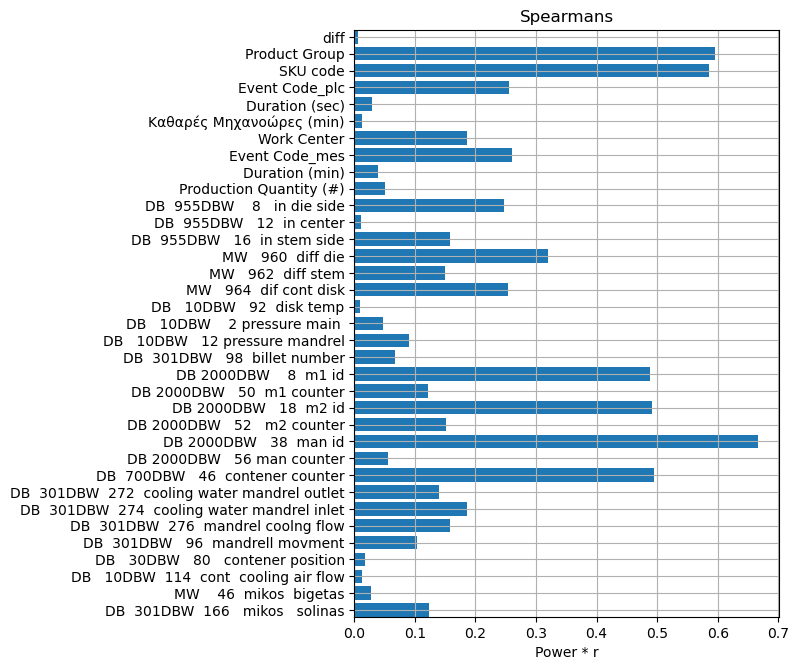

<Figure size 640x480 with 0 Axes>

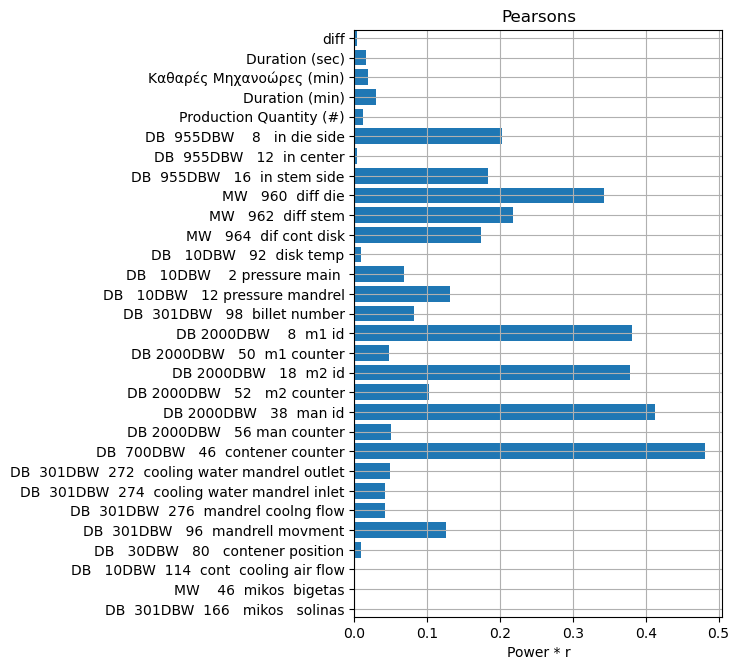

In [25]:
total_energy1_without_timestamp = total_energy1.drop(columns=['Timestamp'])
data = ("Real Energy", total_energy1_without_timestamp)
results = simple_algorithms(data)
for res in results:
   corellationData = res[0]
   corellationData['pow*r'] = corellationData.apply(lambda row: abs(row.r) * row.power, axis=1)
   corellationData=corellationData.dropna().reset_index()
   plt.figure()
   fig, ax = plt.subplots()
   ax.barh(np.arange(len(corellationData['index'])), corellationData['pow*r'], align='center')
   ax.set_yticks(np.arange(len(corellationData['index'])), labels=corellationData['index'])
   ax.invert_yaxis()  # labels read top-to-bottom
   ax.set_xlabel('Power * r')
   ax.set_title(res[1])
   plt.grid()
   plt.gca().margins(y=0)
   plt.gcf().canvas.draw()
   tl = plt.gca().get_yticklabels()
   maxsize = max([t.get_window_extent().height for t in tl])
   m = 0.2 # inch margin
   s = maxsize/plt.gcf().dpi*len(corellationData['index'])+2*m
   margin = m/plt.gcf().get_size_inches()[1]
   plt.gcf().subplots_adjust(bottom=margin, top=1.-margin)
   plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[0])
   os.makedirs("./Plots", exist_ok=True)
   plt.savefig(f'./Plots/correlations_{res[1]}.png',dpi=600)
   plt.show()

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    results = run_complex(data)
    print('Analysis done for:')
    print([res[1] for res in results])

running pearson
running spearman
running kendall
running bicor
running percbend
running shepherd
running skipped


Diagramm for pearson correlation.


<Figure size 640x480 with 0 Axes>

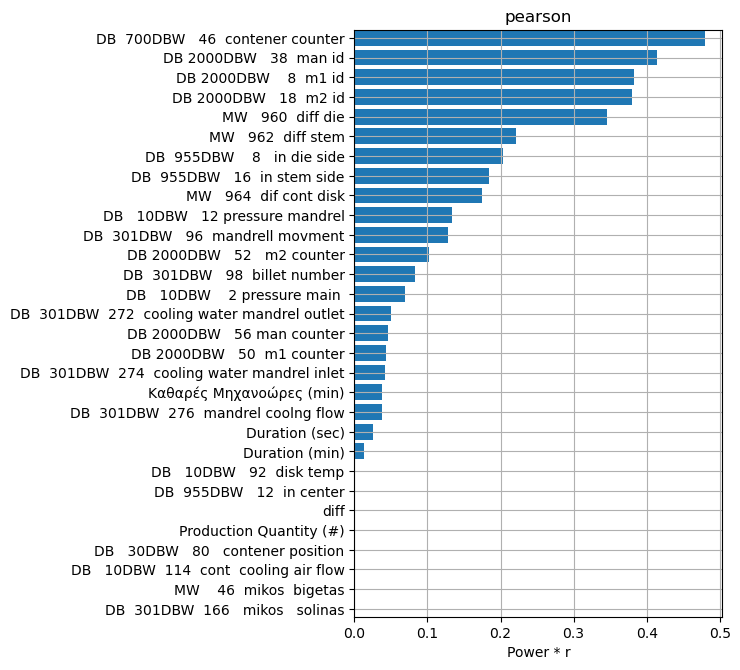

Diagramm for spearman correlation.


<Figure size 640x480 with 0 Axes>

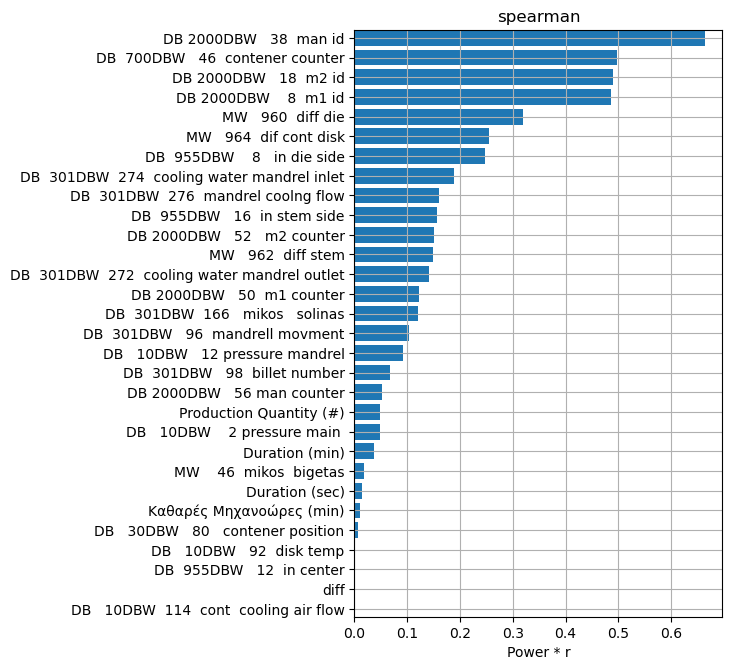

Diagramm for kendall correlation.


<Figure size 640x480 with 0 Axes>

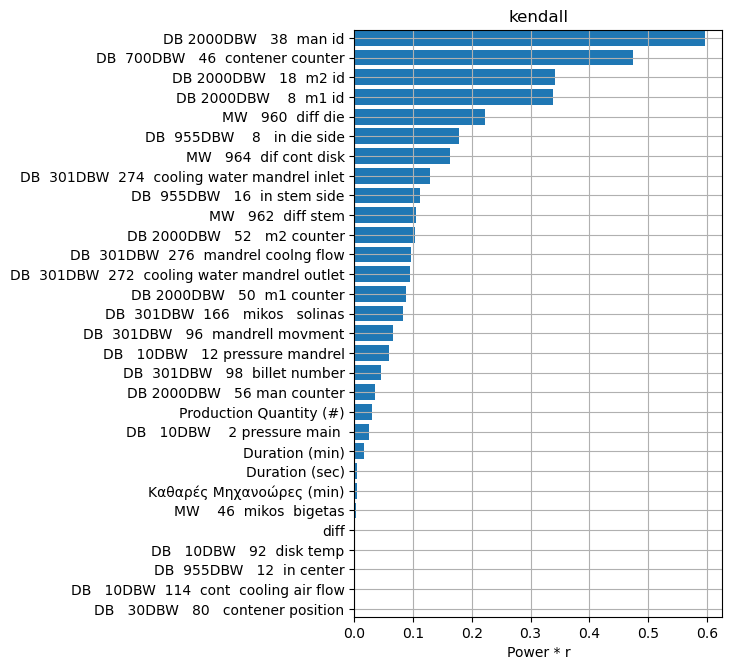

Diagramm for bicor correlation.


<Figure size 640x480 with 0 Axes>

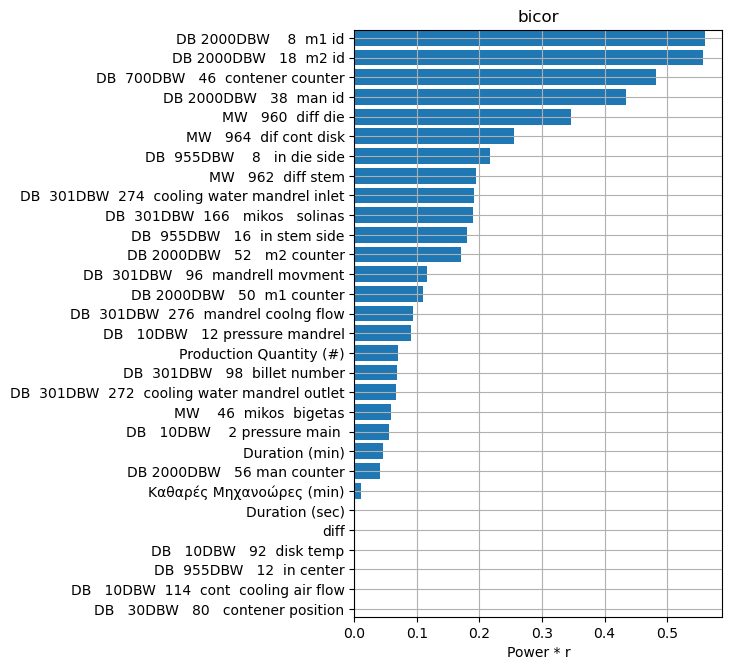

Diagramm for percbend correlation.


<Figure size 640x480 with 0 Axes>

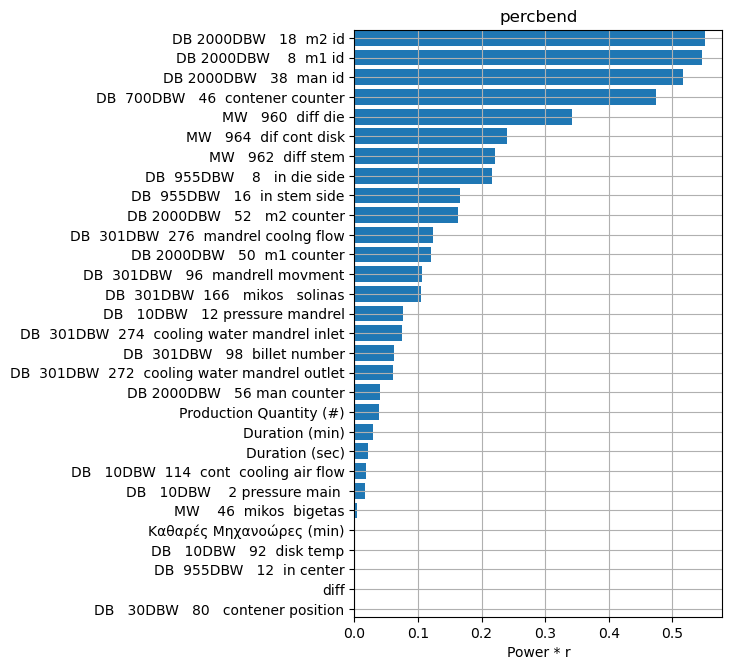

Diagramm for shepherd correlation.


<Figure size 640x480 with 0 Axes>

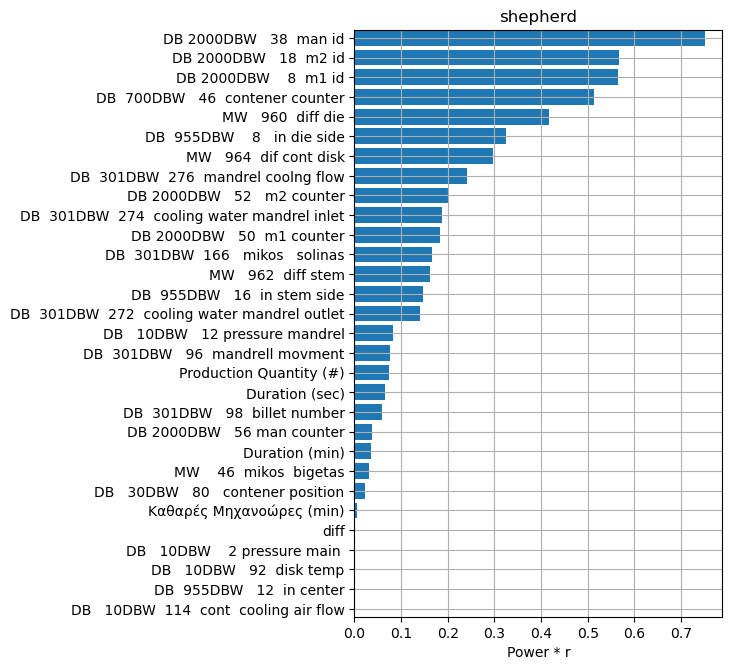

Diagramm for skipped correlation.


<Figure size 640x480 with 0 Axes>

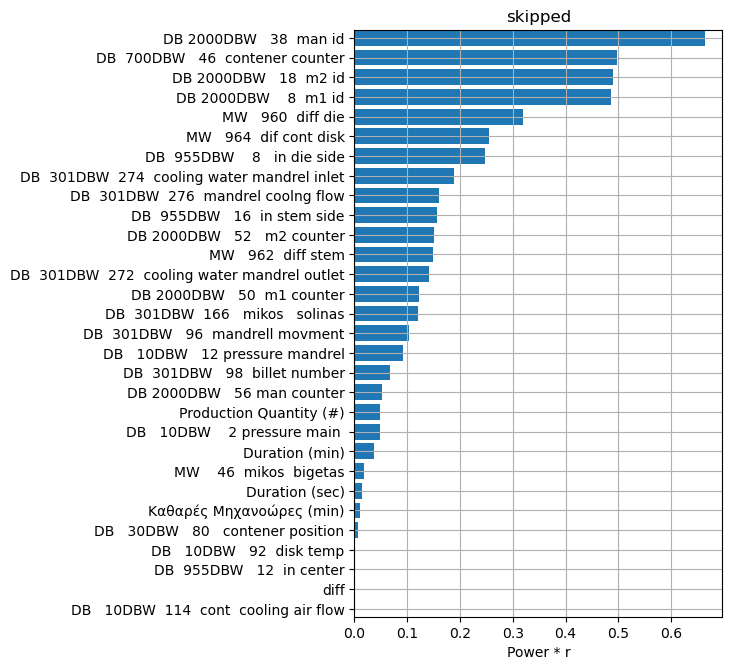

<Figure size 640x480 with 0 Axes>

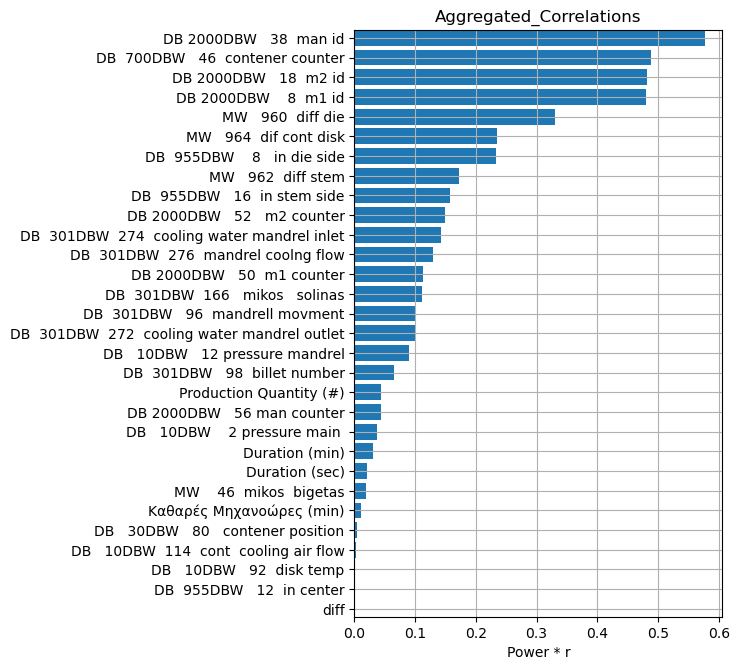

In [ ]:
for res in results:
    try:
        corellationData = res[0]
        print(f'Diagramm for {res[1]} correlation.')
        corellationData['pow*r'] = corellationData.apply(lambda row: abs(row['r']) * row['power'] if row['p-val']<0.15 else 0.0, axis=1)
        corellationData=corellationData.dropna().sort_values(by='pow*r',ascending=False).reset_index()
        plt.figure()
        fig, ax = plt.subplots()
        ax.barh(np.arange(len(corellationData['index'])), corellationData['pow*r'], align='center')
        ax.set_yticks(np.arange(len(corellationData['index'])), labels=corellationData['index'])
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Power * r')
        ax.set_title(res[1])
        plt.grid()
        plt.gca().margins(y=0)
        plt.gcf().canvas.draw()
        tl = plt.gca().get_yticklabels()
        maxsize = max([t.get_window_extent().height for t in tl])
        m = 0.2 # inch margin
        s = maxsize/plt.gcf().dpi*len(corellationData['index'])+2*m
        margin = m/plt.gcf().get_size_inches()[1]
        plt.gcf().subplots_adjust(bottom=margin, top=1.-margin)
        plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[0])
        plt.savefig(f'./Plots/correlations_{res[1]}.png',dpi=600)
        plt.show()
    except Exception as ex:
        print()
        print(ex)
        print()
aggregated_res = pd.concat([res[0] for res in results]).reset_index().groupby(['index']).mean().reset_index().sort_values(by='pow*r',ascending=False)
plt.figure()
fig, ax = plt.subplots()
ax.barh(np.arange(len(aggregated_res['index'])), aggregated_res['pow*r'], align='center')
ax.set_yticks(np.arange(len(aggregated_res['index'])), labels=aggregated_res['index'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Power * r')
ax.set_title("Aggregated_Correlations")
plt.grid()
plt.gca().margins(y=0)
plt.gcf().canvas.draw()
tl = plt.gca().get_yticklabels()
maxsize = max([t.get_window_extent().height for t in tl])
m = 0.2 # inch margin
s = maxsize/plt.gcf().dpi*len(aggregated_res['index'])+2*m
margin = m/plt.gcf().get_size_inches()[1]
plt.gcf().subplots_adjust(bottom=margin, top=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[0])
plt.savefig(f'./Plots/correlations_aggregated.png',dpi=600)
plt.show()